Forecasting electricity demand is an extremely relevant problem for energy providers, as it influences not only the cost of day to day operations but also the timeliness and effectiveness of preparing for extreme weather conditions. Additionally, providers have to account for variations in geographic locations, further increasing the complexity of forecasting tasks. 

In this blog post, I aim to apply the Prophet forecasting model on the Australian New South Wales Electricity Market dataset, which features the electricity price and demand of New South Wales and Victoria, as well as the amount transferred between the two states. 

The data contains 45,312 instances for the days from May 7, 1996 to December 5, 1998, with observations recorded every half hour in each 24 hour period. I account for this granularity with a multiple seasonality approach.

In [1]:
#| echo: false
#| label: library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sktime.split import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sktime.utils.plotting import plot_series, plot_lags, plot_correlations
from sktime.transformations.series.detrend import STLTransformer
from sktime.transformations.series.detrend.mstl import MSTL

from sktime.forecasting.statsforecast import StatsForecastMSTL
from sktime.forecasting.fbprophet import Prophet

In [2]:
#| echo: false
#| cache: true
#| label: read and process data

electricity = pd.read_csv("C:/Users/jrh25/Desktop/personal-site/data/electricity.csv")
electricity['day'] = electricity['day'].str.replace("b'", "").str.replace("'", "")
electricity['class'] = electricity['class'].str.replace("b'", "").str.replace("'", "")

In [3]:
#| echo: true

electricity.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN


The data has a very fine level of granularity, making for a highly dense time series plot for the entire series. Right off the bat we can observe a longer term seasonality in the trend line of the graph.

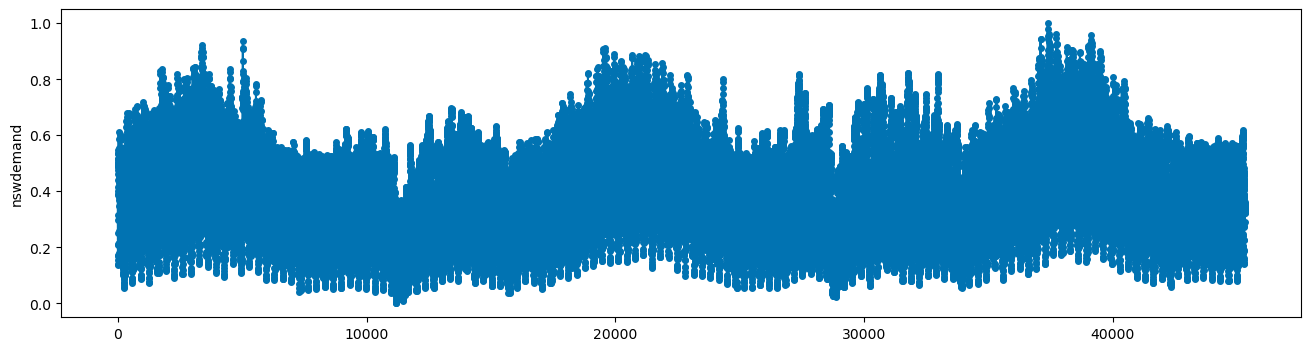

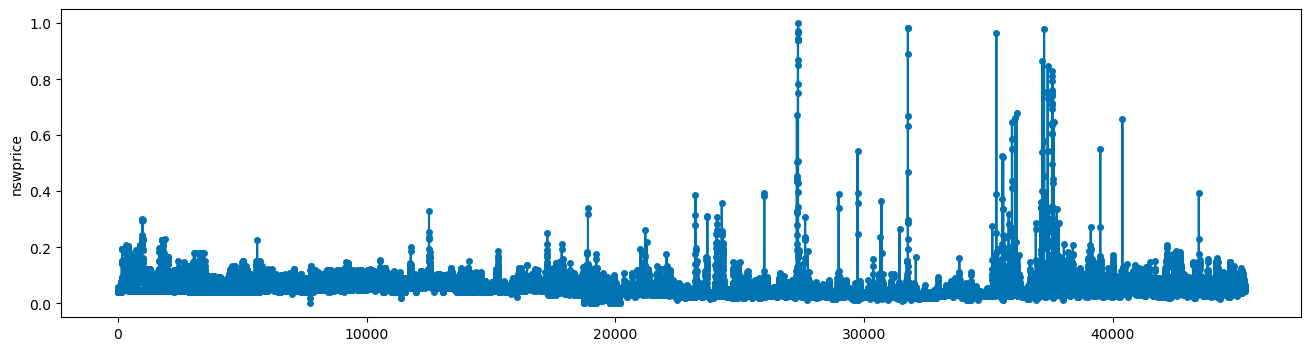

In [4]:
fig, ax = plot_series(electricity['nswdemand'])
fig, ax = plot_series(electricity['nswprice'])

Plotting a couple smaller length sections of the series (in intervals of 1000 observations) lets us see smaller scale seasonalities, which are immediately discernable.

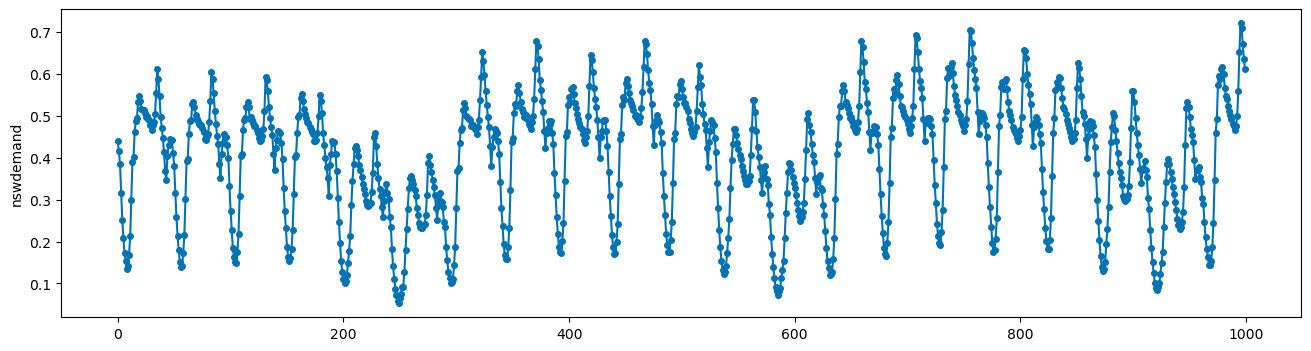

In [5]:
fig, ax = plot_series(electricity['nswdemand'][0:1000])

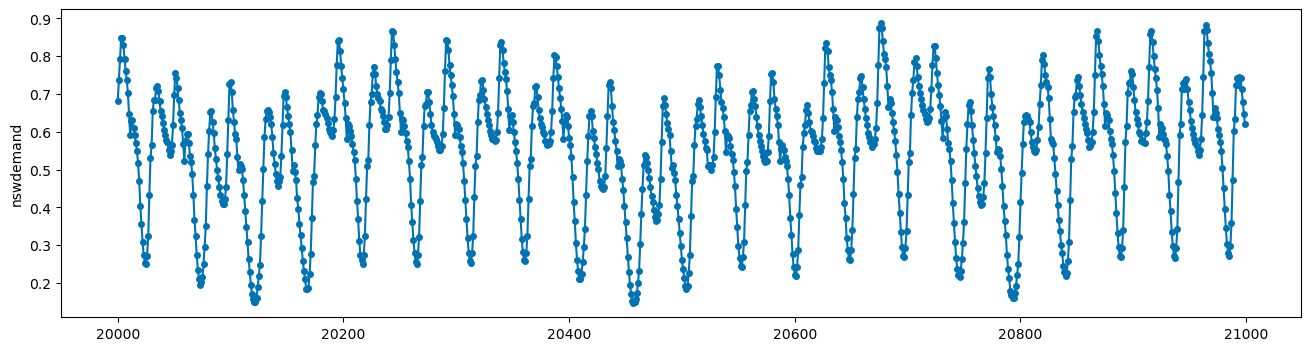

In [6]:
fig, ax = plot_series(electricity['nswdemand'][20000:21000])

### EDA

The magnitude of seasonal variations doesn't appear to be influenced by the length of the time series, so I assume an additive decomposition to be the most appropriate such that

$y_t = S_t + T_t + R_t$

where data is decomposed into seasonal, trend, and remainder components respectively.

This data doesn't contain any missing values:

In [7]:
# Checking for missing values
missing_values = electricity.isna().sum()
print(missing_values)

date         0
day          0
period       0
nswprice     0
nswdemand    0
vicprice     0
vicdemand    0
transfer     0
class        0
dtype: int64


Now let's perform an STL decomposition to get an idea of the seasonal and trend-cycle components of our data.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='resid'>)

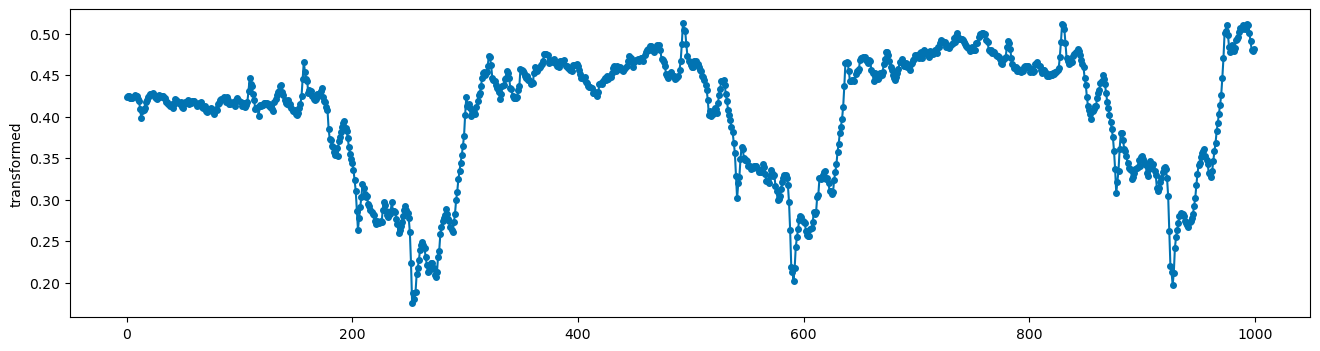

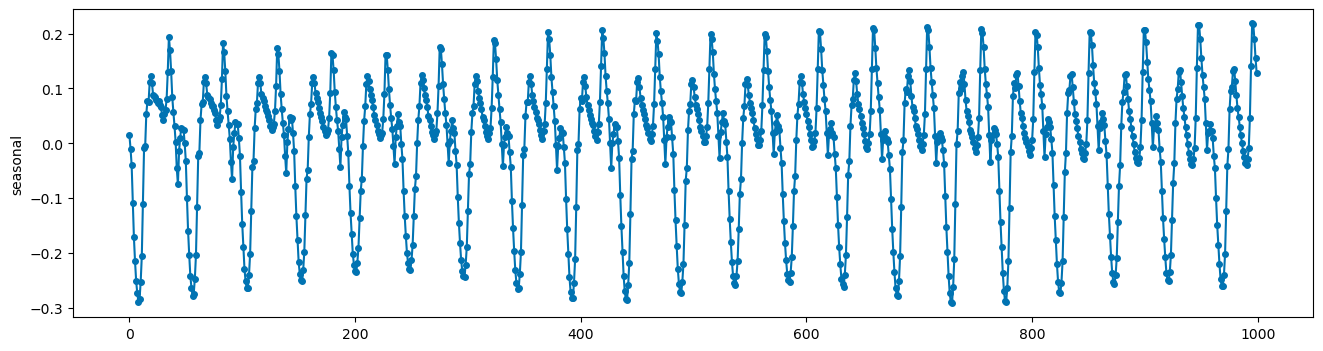

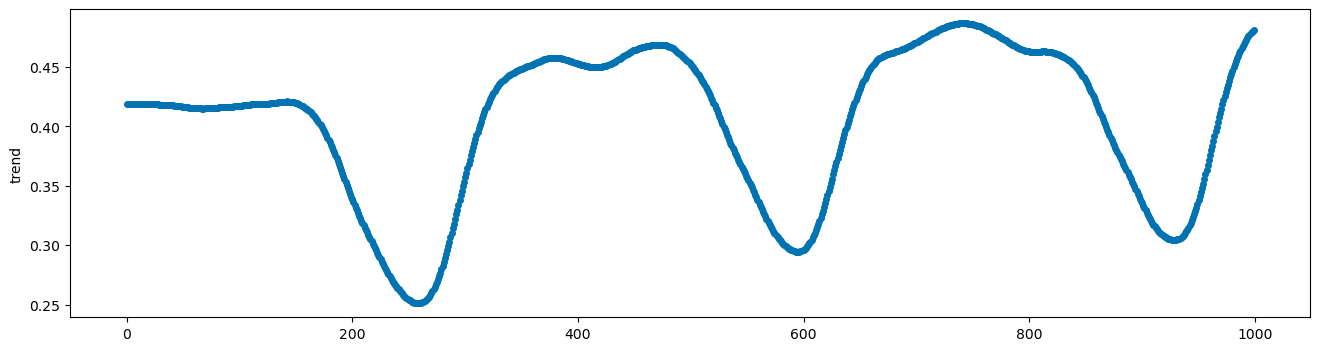

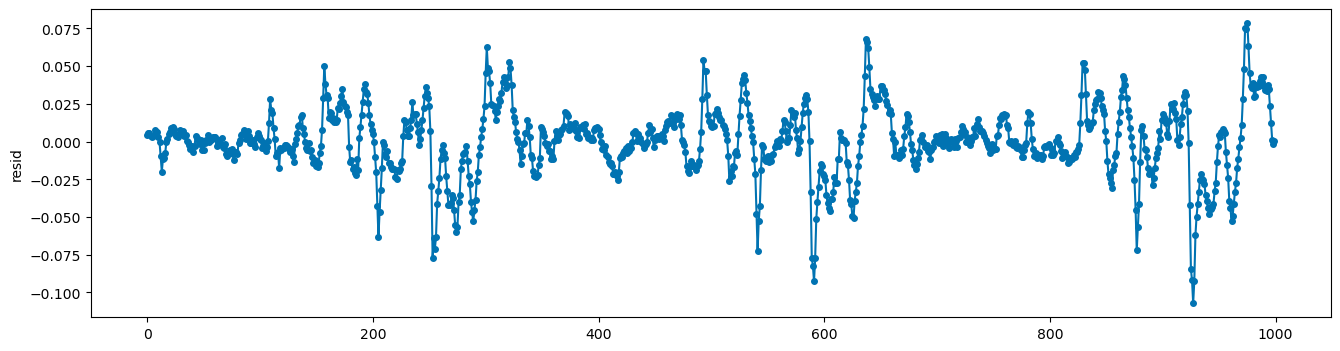

In [8]:
stl = STLTransformer(return_components=True, sp=48)
y_stl = stl.fit_transform(electricity['nswdemand'])
plot_series(y_stl['transformed'][0:1000])
plot_series(y_stl['seasonal'][0:1000])
plot_series(y_stl['trend'][0:1000])
plot_series(y_stl['resid'][0:1000])

Performing an STL transform with a periodicity of 48 (representing one day) eliminates the hourly seasonality from the time series, revealing the trend line as shown above, which appears to still contain weekly seasonality. We can make an educated guess that there'll also be yearly seasonality, given the correlation between electricity demand and seasonal changes in weather. I'll run STL transform again to extract out the weekly/yearly seasonalities.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='resid'>)

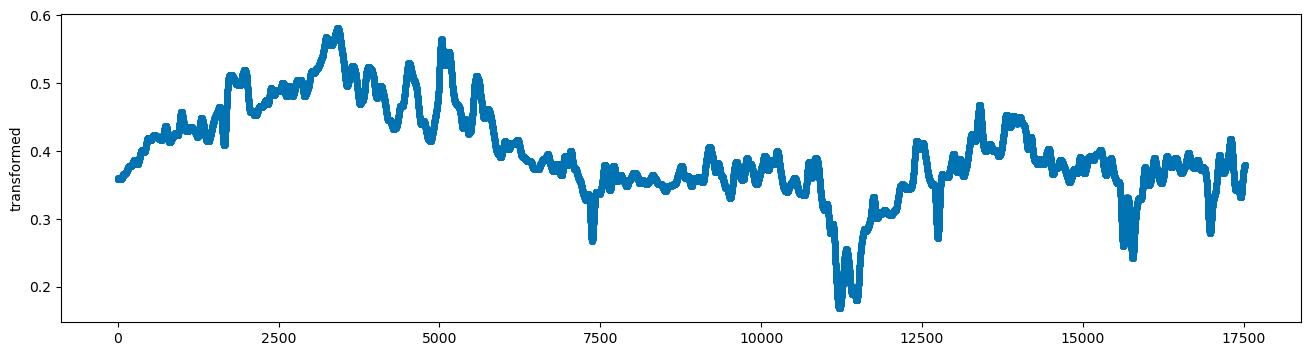

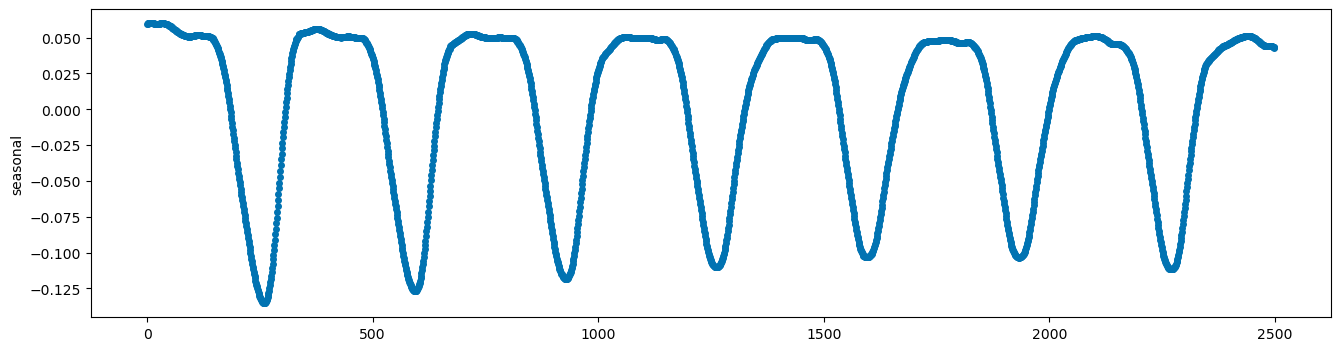

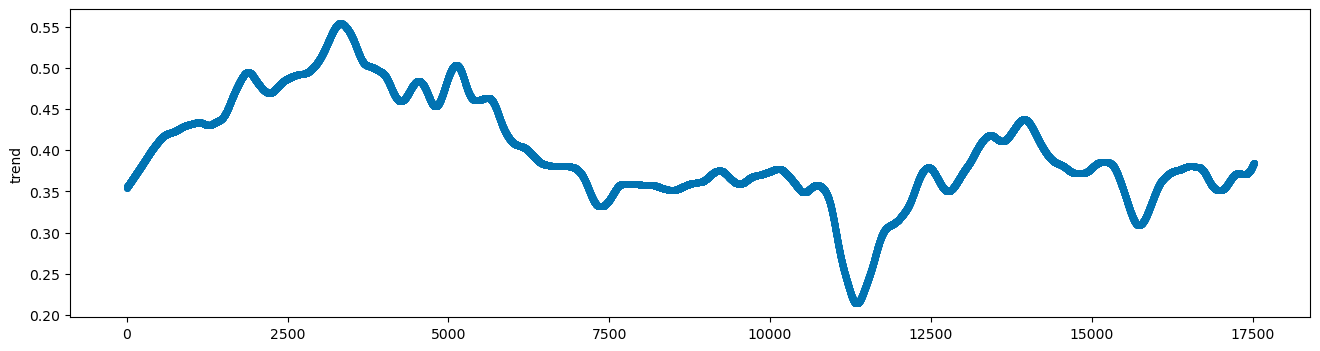

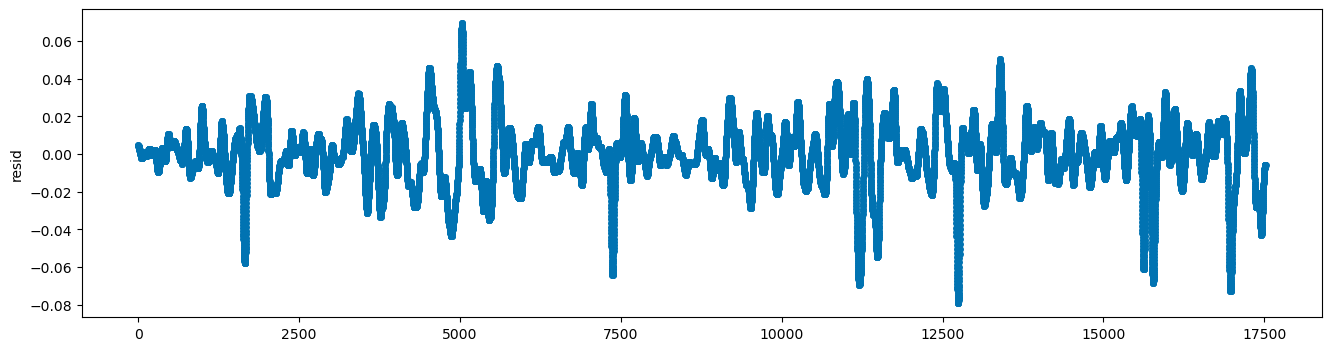

In [9]:
stl2 = STLTransformer(return_components=True, sp=48*7)
y_stl2 = stl2.fit_transform(y_stl['trend'])
plot_series(y_stl2['transformed'][0:17520])
plot_series(y_stl2['seasonal'][0:2500])
plot_series(y_stl2['trend'][0:17520])
plot_series(y_stl2['resid'][0:17520])

It becomes more complicated to eyeball any obvious seasonalities from the trend cycle after extracting the weekly seasonalities. Some R packages such as feasts may provide more powerful tools for breaking down the short/long term seasonalities and features in the series, but for now this works as EDA.

A closer look at the daily seasonality present in the data (2 periods, 1 periods plotted below):

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='nswdemand'>)

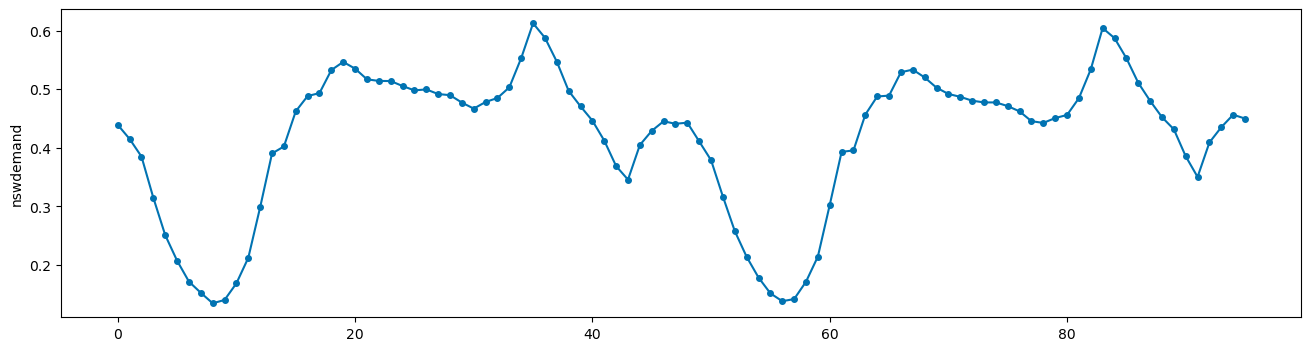

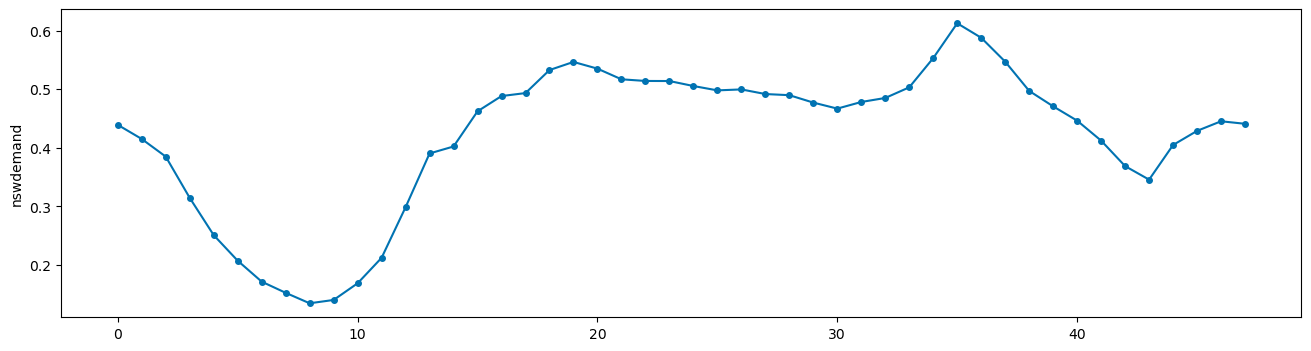

In [10]:
plot_series(electricity['nswdemand'][0:96])
plot_series(electricity['nswdemand'][0:48])

#### Prophet Model

Prophet is a model developed by Facebook for use in commercial forecasting applications; it has strong out of the box performance in data containing multiple seasonalities and holiday effects. I use a downgraded 1.1.5 version of Prophet due to optimization errors that arise with the 1.1.6 version. 

Hyndman does a brief breakdown of the model and its structure. Prophet works as an additive model:

$y(t) = g(t) + s(t) + h(t) + \epsilon_t$ 

Which adds the trend $g(t)$ as a piecewise linear model, the seasonality $s(t)$ as fourier terms, the holiday effects $h(t)$ as dummy variables, and additional noise $\epsilon_t$. The model estimates changepoints and other structures through a Bayesian MCMC approach. Facebook's Prophet has cmdstan as a dependency, but I've found a very detailed breakdown/implementation of the model using PyMC in [this blog post](https://www.ritchievink.com/blog/2018/10/09/build-facebooks-prophet-in-pymc3-bayesian-time-series-analyis-with-generalized-additive-models/). 

While the smallest level of granularity in some time series occurs through daily instances, this dataset has observations ever half-hour, meaning the period should be 48 for daily seasonality, 336 for weekly, and so on. We'll have to add these as custom seasonalities to our Prophet model; this is accomplished by adding new custom seasonalities using the add_seasonality argument provided by the sktime wrapper.

Since we're using sktime, it has a slightly different way of handling add_seasonality() than in fbprophet; we have to add multiple custom seasonalities as a list of dictionaries to the constructor.

In [5]:
y = electricity['nswdemand']
y_train, y_test = temporal_train_test_split(y, test_size=0.2)
forecaster = Prophet(
    seasonality_mode='additive',
    add_country_holidays={'country_name': 'Australia'},
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    add_seasonality=[{
        'name': 'daily-cycle',
        'period': 48, # period of 48 representing observations per day
        'fourier_order': 12
    },
    {
        'name': 'weekly-cycle',
        'period': 336, # period of 336 representing 7 day (weekly) cycle
        'fourier_order': 3
    },
    {
        'name': 'yearly-cycle',
        'period': 17520,
        'fourier_order': 10
    }]
)
forecaster.fit(y_train)

Importing plotly failed. Interactive plots will not work.
19:47:37 - cmdstanpy - INFO - Chain [1] start processing
19:48:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet(add_country_holidays={'country_name': 'Australia'},
        add_seasonality=[{'fourier_order': 12, 'name': 'daily-cycle',
                          'period': 48},
                         {'fourier_order': 3, 'name': 'weekly-cycle',
                          'period': 336},
                         {'fourier_order': 10, 'name': 'yearly-cycle',
                          'period': 17520}],
        daily_seasonality=True, weekly_seasonality=True,
        yearly_seasonality=True)

We then evaluate model performance with mean average percentage error, mean absolute error, and mean squared error.

In [6]:
# Specify forecasting horizon and pass on to forecasting algorithm
y_pred = forecaster.predict(np.arange(len(y_test)))
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"MAPE: {mape} \nMAE: {mae} \nMSE: {mse}")


MAPE: 0.15347452360520786 
MAE: 0.060155303375532855 
MSE: 0.006071706056646205


These look like pretty decent results for a model that isn't being exhaustively tuned/optimized (we could go on further with grid-search, cross validation, using other metrics like AIC or BIC, but this is already a solid benchmark for Prophet's capabilities).

Let's visually see how our forecasts measure up to the actual values.

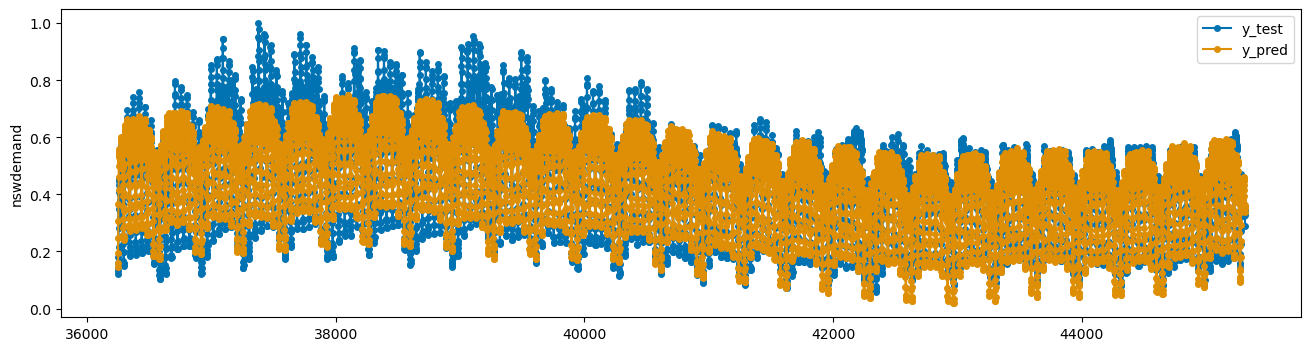

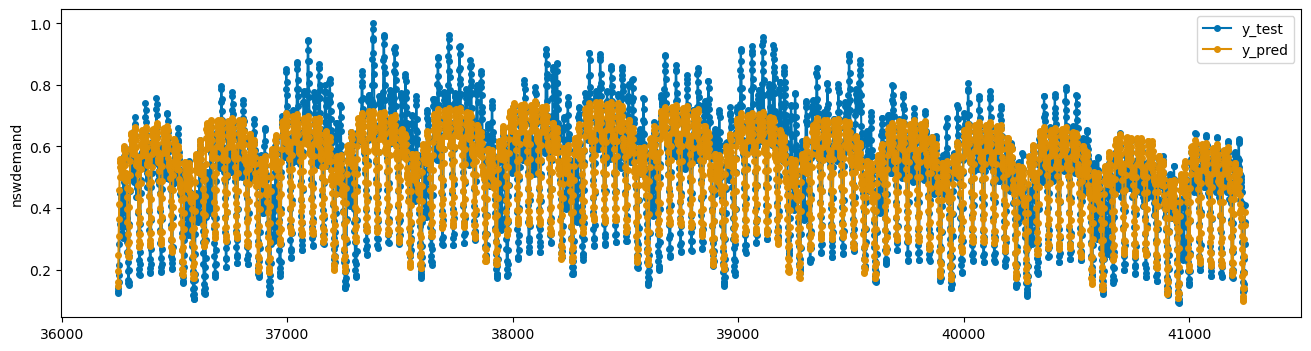

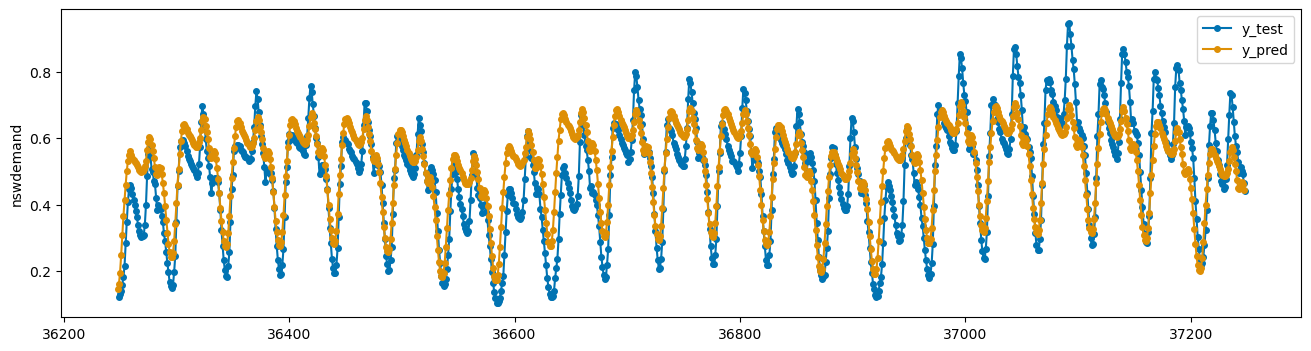

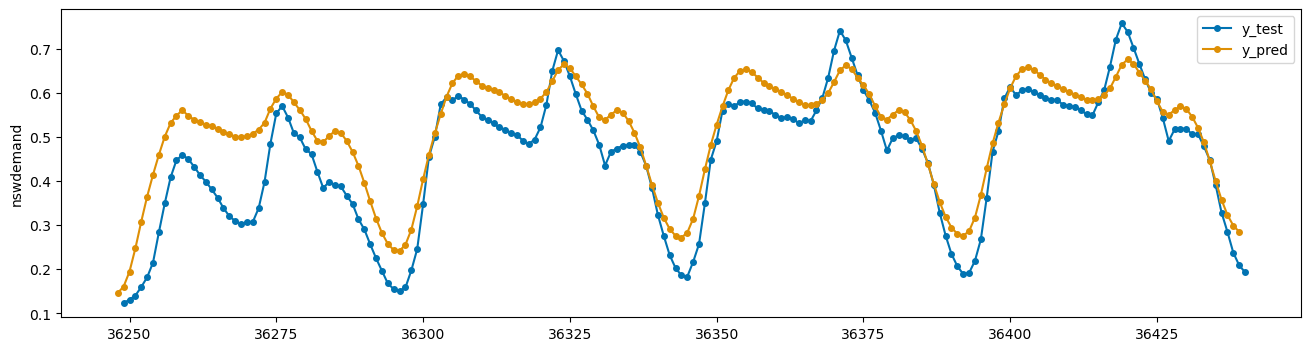

In [7]:
fig, ax = plot_series(y_test, y_pred, labels=["y_test", "y_pred"])
fig, ax = plot_series(y_test[0:5000], y_pred[0:5000], labels=["y_test", "y_pred"])
fig, ax = plot_series(y_test[0:1000], y_pred[0:1000], labels=["y_test", "y_pred"])
fig, ax = plot_series(y_test[0:192], y_pred[0:192], labels=["y_test", "y_pred"])

We can plot the residuals to observe for any remaining seasonal patterns that weren't captured by our model.

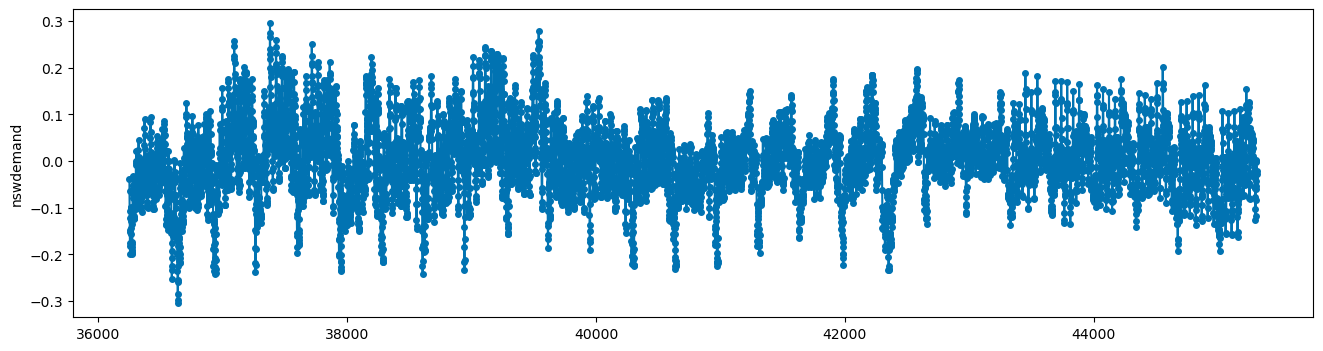

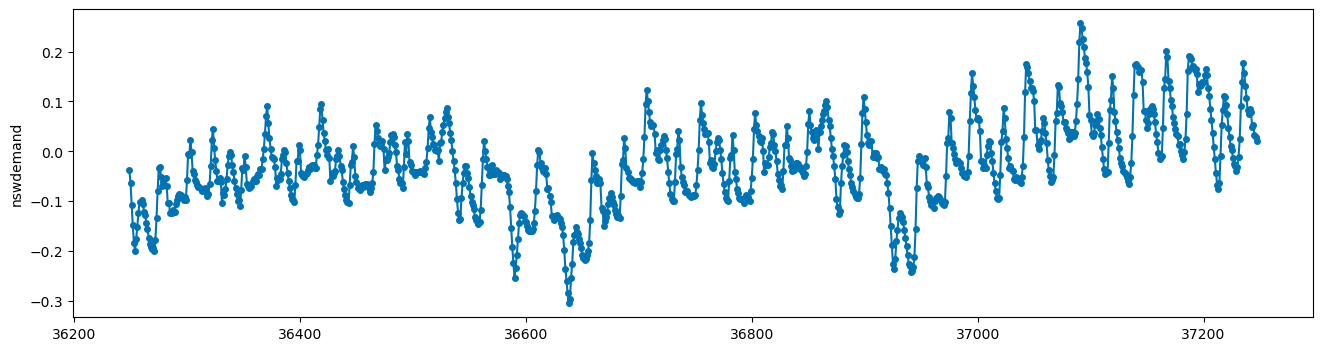

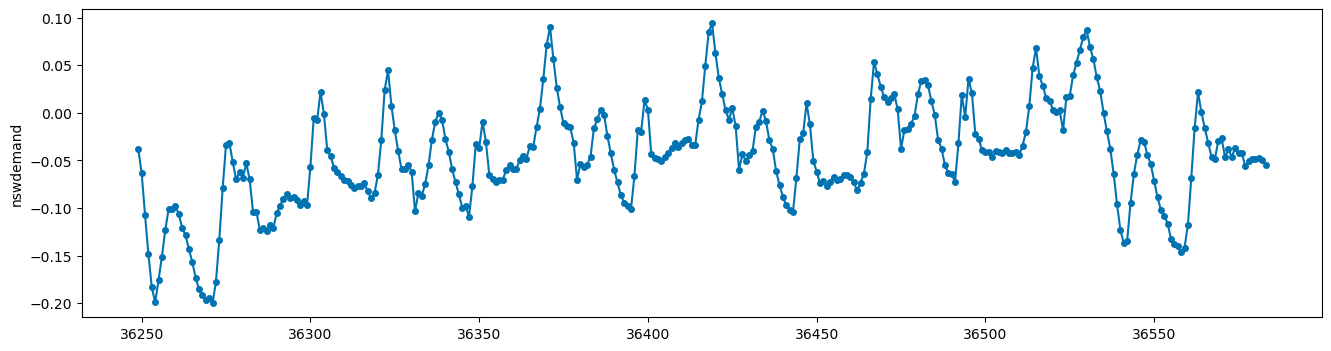

In [15]:
fig, ax = plot_series(y_test[0:17520]-y_pred[0:17520])
fig, ax = plot_series(y_test[0:1000]-y_pred[0:1000])
fig, ax = plot_series(y_test[0:336]-y_pred[0:336])

As can be seen, we've captured a good deal of the daily, weekly, and yearly seasonalities from the original data from our forecast. However, there remains additional patterns in the data that we haven't accounted for. Specifically, it appears that during the first half of the year -in the summer months- the energy demand spikes much more frequently than in the latter half, likely due to the use of air conditioning.

This shows how useful Prophet is in a situation where you're able to clearly identify your seasonalities; without requiring any underlying knowledge of how the model works, it's simple to fit a decent forecaster that captures most of the patterns in your data.

### Multiple Seasonal-Trend Forecasting

Other methods are also just as performant. For example, the Multiple Seasonal-Trend Decomposition using Loess (MSTL)  algorithm developed by [Bandara, Hyndman, and Bergmeir](https://arxiv.org/abs/2107.13462) handles multiple seasonal patterns well, which is exactly what our dataset exhibits. We saw above that I had to perform regular STL multiple times on the data because it exhibited multiple levels of seasonality at the daily, weekly, and yearly levels. With MSTL we still assume an additive decomposition, this time with the following structure:

$y_t = S_t^{(1)} + S_t^{(2)} + ... + S_t^{(n)} + T_t + R_t$

With multiple terms for multiple seasonal components. 


Index(['trend', 'resid', 'seasonal_48', 'seasonal_336'], dtype='object')


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='nswdemand'>)

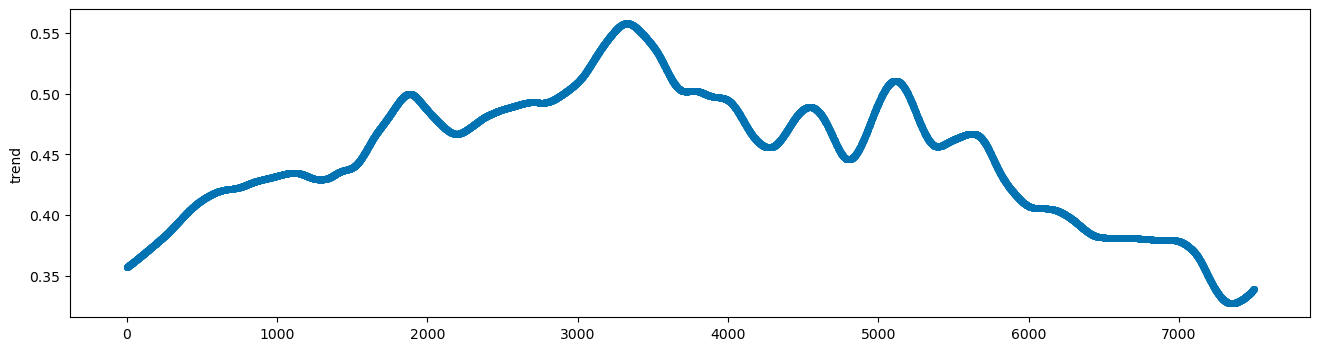

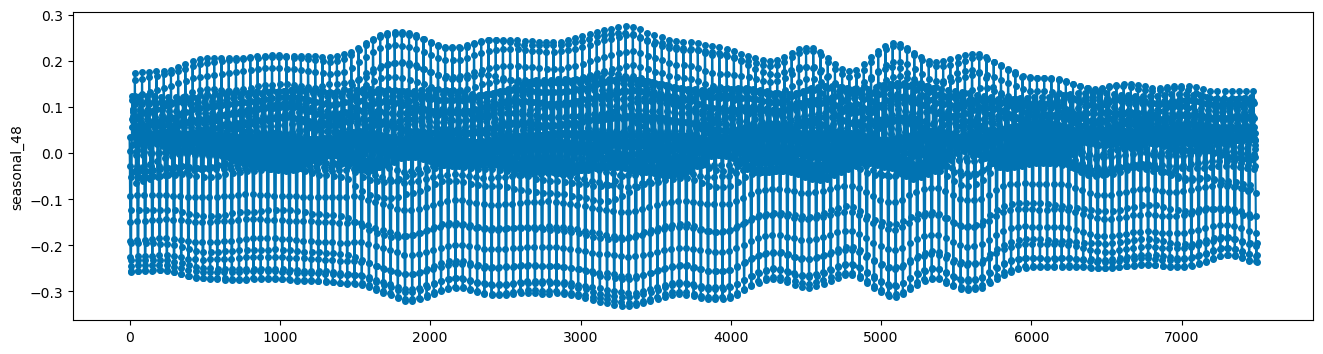

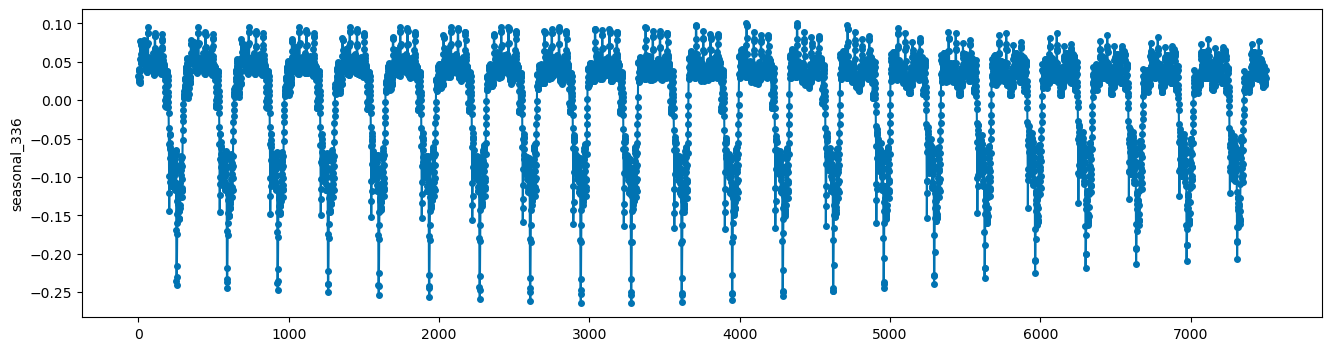

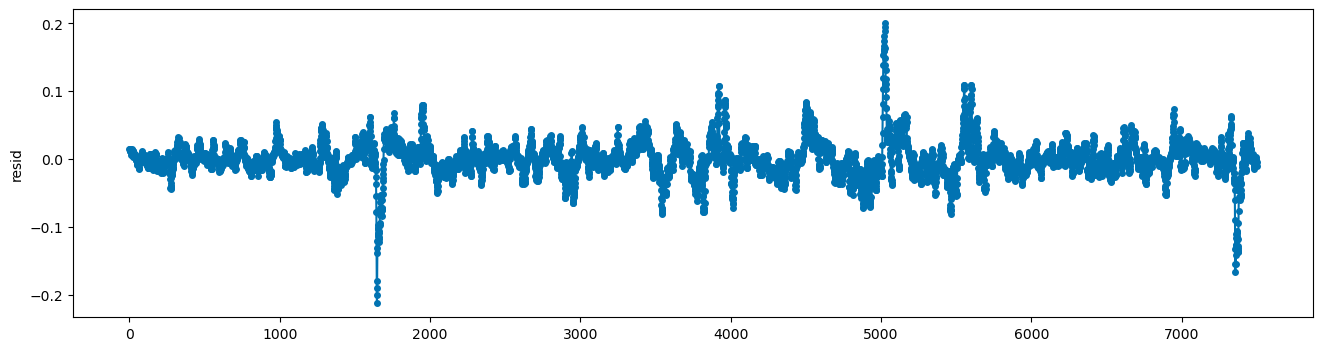

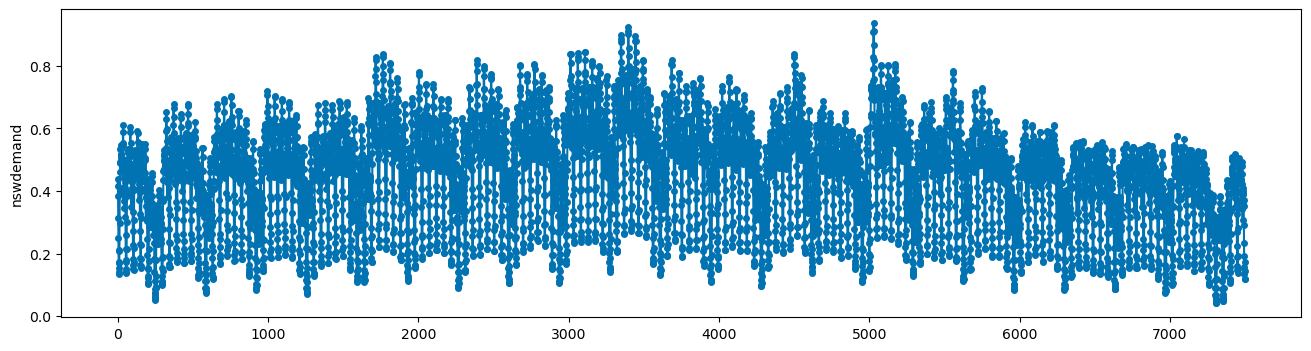

In [9]:
mstl = MSTL(periods=[48, 48*7], return_components=True)
mstl_components = mstl.fit_transform(y)
print(mstl_components.columns)
plot_series(mstl_components['trend'][0:7500])
plot_series(mstl_components['seasonal_48'][0:7500])
plot_series(mstl_components['seasonal_336'][0:7500])
plot_series(mstl_components['resid'][0:7500])
plot_series(y[0:7500])

A closer look at the seasonal components for daily (period=48) and weekly (period=336) seasonalities:

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='seasonal_336'>)

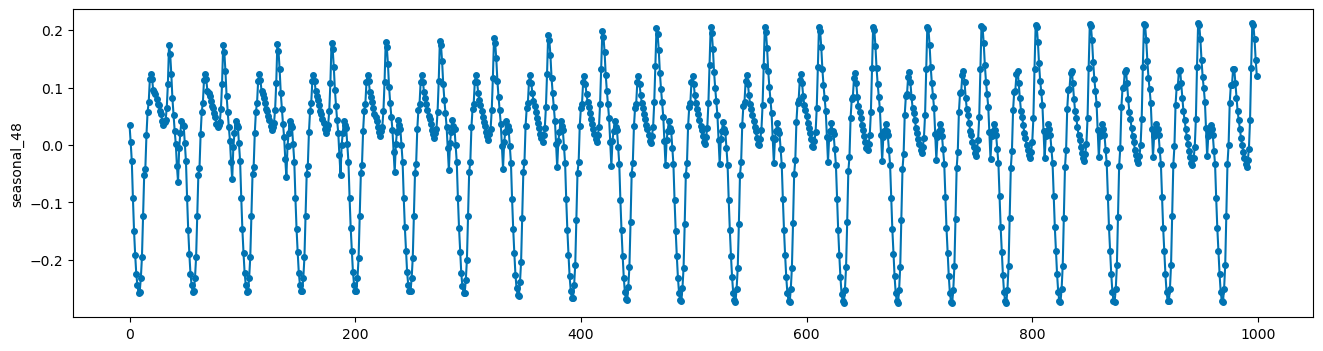

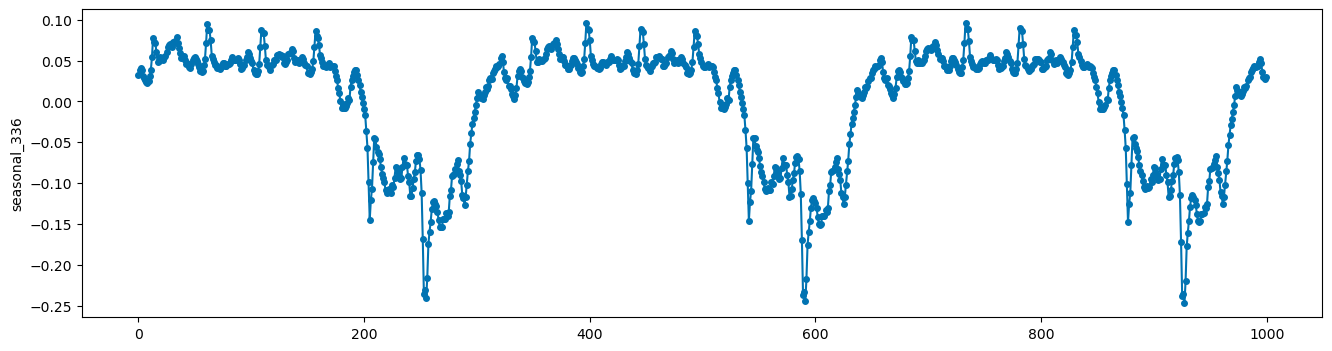

In [10]:
plot_series(mstl_components['seasonal_48'][0:1000])
plot_series(mstl_components['seasonal_336'][0:1000])

These separate seasonal components reflecct the daily and weekly cycles of energy demand that I saw earlier using STL iteratively on the dataset. We can see how electricity demand falls at certain parts of the day and peaks in others. Additionally, we see how electricity demand falls in two days of the week (weekend) as opposed to working days. We can incorporate the results of the MSTL inside sktime's StatsForecastMSTL class model, which interfaces with Nixtla's implementation.

I fit the forecaster with arguments for daily, weekly, and yearly seasonalities relative to the dataset:

In [11]:
model = StatsForecastMSTL(season_length=[48, 48*7, 48*365])
forecaster = model.fit(y=y_train)

And now for evaluating model performance:

In [12]:
y_pred = forecaster.predict(np.arange(len(y_test)))
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"MAPE: {mape} \nMAE: {mae} \nMSE: {mse}")

MAPE: 0.1522244466461589 
MAE: 0.0591753040252963 
MSE: 0.005841216097518591


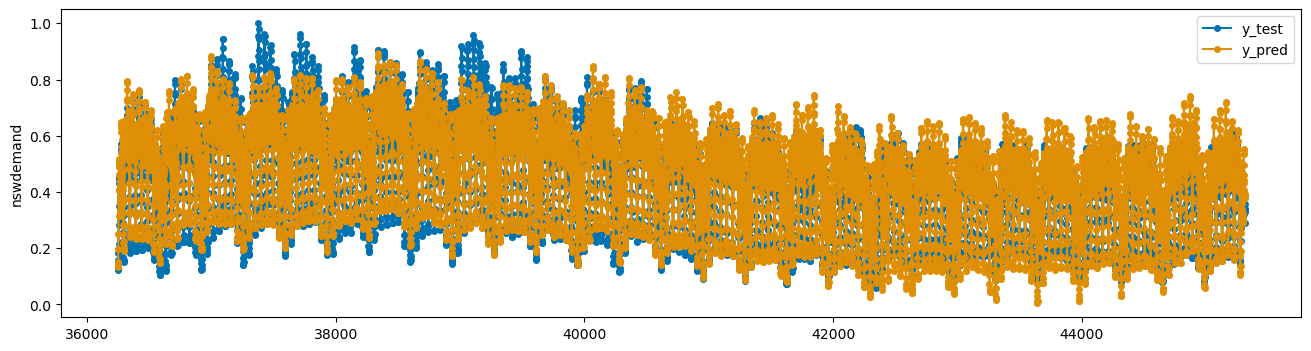

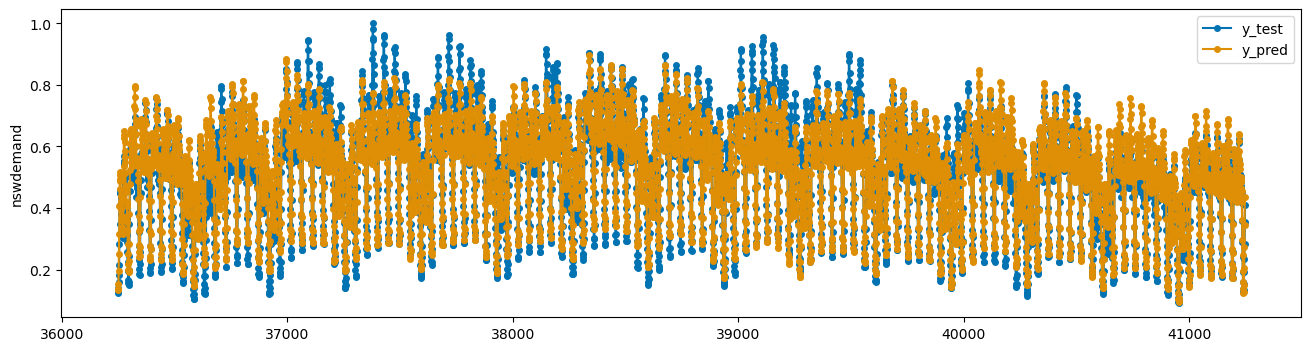

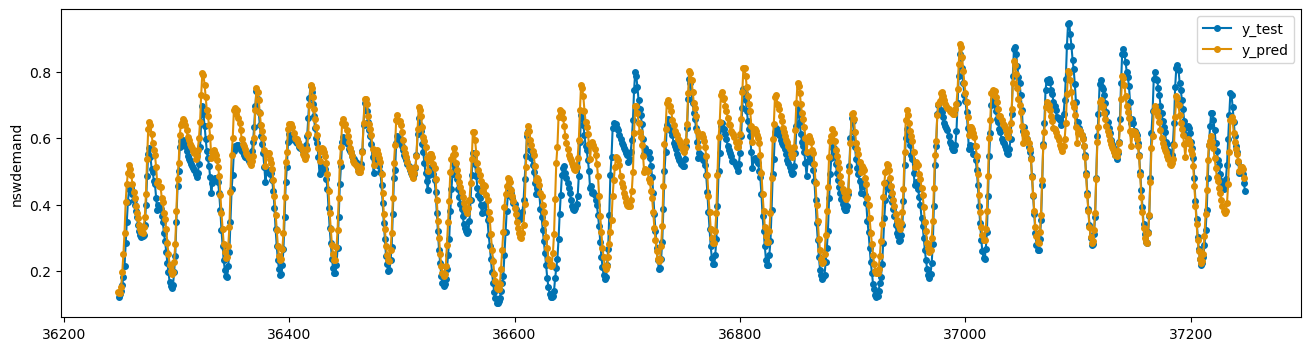

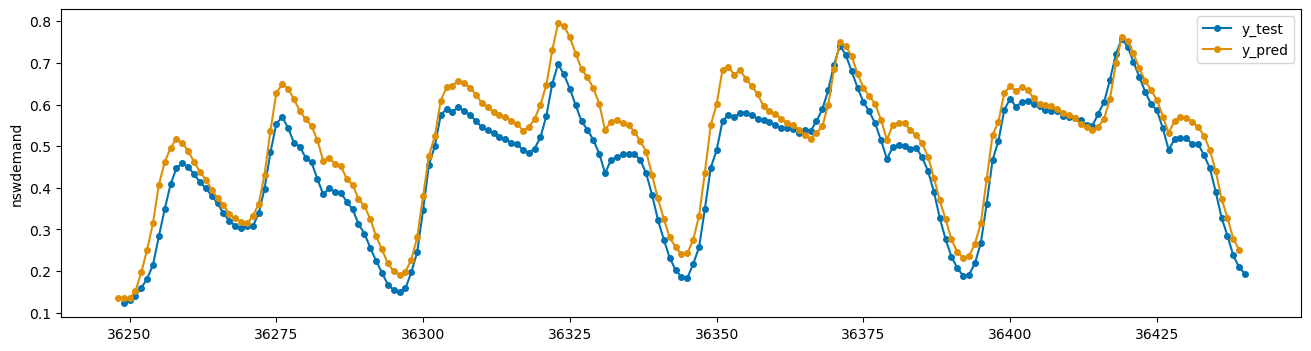

In [13]:
fig, ax = plot_series(y_test, y_pred, labels=["y_test", "y_pred"])
fig, ax = plot_series(y_test[0:5000], y_pred[0:5000], labels=["y_test", "y_pred"])
fig, ax = plot_series(y_test[0:1000], y_pred[0:1000], labels=["y_test", "y_pred"])
fig, ax = plot_series(y_test[0:192], y_pred[0:192], labels=["y_test", "y_pred"])

We can see that forecasting using this method performs just as, if not slightly better than Prophet. In the background, the series is decomposed with MSTL and then the trend and seasonality are forecasted using various other models (can consult this [documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.statsforecast.StatsForecastMSTL.html) to find out more).

We're able to capture the daily, weekly, and yearly seasonalities that we saw in previous stages inside this forecast, but one thing of note is that this method was incredibly inefficient on the dataset, which makes sense. Given seasonal periods of length 48, 336, and 17520 (representing daily, weekly, and yearly cycles) the model has to estimate many more coefficients and the overall fitting process is much more computationally expensive (it took me around 20 minutes to run the model fitting on my device).

Compare this to the Prophet model, where we were able to fit the model in just 30 seconds by adding exogenous Fourier terms to account for the seasonalities, and it's easy to see the tradeoffs.